##   Name: VIKNESH RAJARAMON                
## ASU ID: 1229281354

In [1]:
import sys; sys.path.append('../..') ; sys.path.append('..') ; from my_utils import *

import torch 
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
# dummy trainloader 
trainloader = data.DataLoader(data.TensorDataset(torch.Tensor(1), torch.Tensor(1)), batch_size=1, shuffle=True) 
device = torch.device('cpu')

import matplotlib.pyplot as plt

In this homework, we build a neural network for performing binary classification. We will base our implementation on neural ordinary differential equations (NODEs). We will again use the concentric annuli dataset. 

Let's begin by importing some libaries. 

Next, we set a random seed for reproducibility.

In [2]:
import numpy as np
import random

seed = 0
np.random.seed(seed)
torch.random.manual_seed(seed)
random.seed(seed)

# Concentric annuli



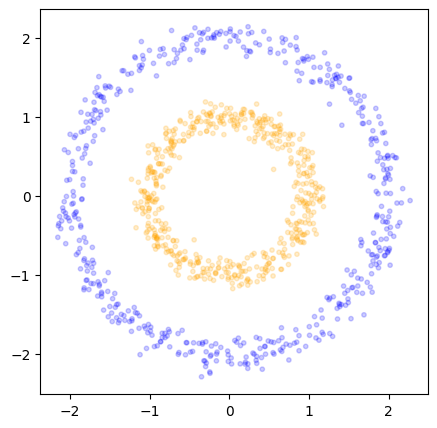

In [3]:
Xtrain, ytrain = sample_annuli()
fig, ax = plt.subplots(1,1, figsize=(5,5))
plot_scatter(ax, Xtrain, ytrain)

First, lets see how a simple shallow neural network would perform. 

In [4]:
class Model(nn.Module):
    def __init__(self,device="cpu"):
        super(Model, self).__init__()

        self.net = nn.Sequential(
            nn.Linear(2,50),
            nn.Tanh(),
            nn.Linear(50,50),
            nn.Tanh(),
            nn.Linear(50,1))
        #for p in self.linear_layer.parameters(): torch.nn.init.zeros_(p)

    def forward(self, x):
        y = self.net(x)
        y = torch.sigmoid(y)
        return y

In [5]:
model = Model().to(device)

In [6]:
optimizer = optim.AdamW(model.parameters(), lr=1e-2, weight_decay=1e-6)

In [7]:
for itr in range(1, 501):
    optimizer.zero_grad()
#    x0, y = sample_annuli(device=device, n_samples=1024)
        
    yh = model(Xtrain)
    loss = nn.BCELoss()(yh.squeeze(), ytrain.float())
    print(itr,loss.item())
    #loss_traj[itr-1] = loss.item()
    loss.backward()
    optimizer.step()

1 0.693945586681366
2 0.6776142120361328
3 0.65314781665802
4 0.6346390843391418
5 0.6130549907684326
6 0.5859909057617188
7 0.5587671995162964
8 0.5281894207000732
9 0.49319687485694885
10 0.4578034281730652
11 0.4197216331958771
12 0.37944117188453674
13 0.33956608176231384
14 0.29894691705703735
15 0.2594902813434601
16 0.2226473093032837
17 0.1881948560476303
18 0.15711228549480438
19 0.13000285625457764
20 0.10624712705612183
21 0.08601050823926926
22 0.06934857368469238
23 0.05547630041837692
24 0.0441865473985672
25 0.035292886197566986
26 0.0282076895236969
27 0.022536076605319977
28 0.01809486746788025
29 0.014660941436886787
30 0.01197374053299427
31 0.009838350117206573
32 0.008139539510011673
33 0.006797654554247856
34 0.005740584805607796
35 0.00490180728957057
36 0.00422627804800868
37 0.003673603292554617
38 0.0032166659366339445
39 0.0028375848196446896
40 0.00252340966835618
41 0.0022633119951933622
42 0.0020474635530263186
43 0.0018669985001906753
44 0.001714373589493

You can see that the model can easily achieve zero error.

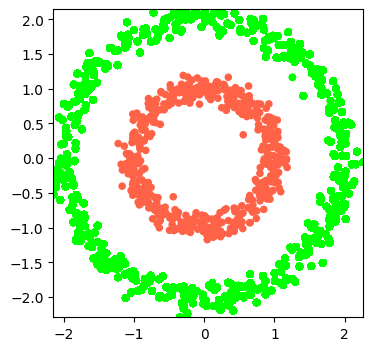

tensor(0)


In [8]:
with torch.no_grad():
    fig = plt.figure(figsize=(4,4))
    axes = []
    axes.append(fig.add_subplot(1,1,1))#,sharex=True,sharey=True))
    xs, ys = Xtrain, ytrain#sample_gaussian(n_samples=200) ; s = torch.linspace(0, 1, 10)
    
    y_pred = model(xs)
    
    label = (y_pred[:,0] >= 0.5).long()
    
    colors = ['lime','tomato']
    for i in range(512):
        axes[0].scatter(xs[i,0], xs[i,1], c=colors[label[i]], edgecolor='none', s=30)
        axes[0].scatter(xs[i+512:,0], xs[i+512:,1], c=colors[label[i+512]], edgecolor='none', s=30)
    axes[0].set_xlim(xs[:,0].min(), xs[:,0].max()) ; axes[0].set_ylim(xs[:,1].min(), xs[:,1].max())
    plt.show()
    err = torch.sum(torch.abs(label) - torch.abs(ytrain))
    print(err)

# NODEs

Now, lets implement neural ODEs for the binary classification.

First, you need to install a proper API, torchdiffeq (https://github.com/rtqichen/torchdiffeq)

In [9]:
from torchdiffeq import odeint

In the following (the ODEFunc class), we define the right-hand side of the neural ODEs ($f$ in the equation below).

$$ \frac{d x}{d t} = f(x;\theta) $$

In [10]:
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()

        hdim = 32
        self.net = nn.Sequential(
            nn.Linear(2, hdim),
            nn.Tanh(),
            nn.Linear(hdim, hdim),
            nn.Tanh(),
            nn.Linear(hdim, 2)
        )

    def forward(self, t, y):
        return self.net(y)

The model below solves the initial value problem associated with the NODE defined above starting at $t=0$ to the terminal time $t=1$.

In [11]:
class Model(nn.Module):
    def __init__(self,odefunc,device="cpu"):
        super(Model, self).__init__()

        self.odefunc = odefunc
        self.linear_layer = nn.Linear(2,1)
        for p in self.linear_layer.parameters(): torch.nn.init.zeros_(p)

    def forward(self, y):
        t_span = torch.linspace(0., 1., 2)
        pred_y = odeint(self.odefunc, y, t_span).to(device)
        yhat = self.linear_layer(pred_y)
        return torch.sigmoid(yhat)

In [12]:
def dec_bound(model, x):
    P = [p for p in model.linear_layer.parameters()]
    w1, w2, b = P[0][0][0].cpu().detach(), P[0][0][1].cpu().detach(), P[1][0].cpu().detach().item()
    return (-w1*x - b + .5)/w2

1 0.6931472420692444
2 0.6930838823318481
3 0.6930156946182251
4 0.6929415464401245
5 0.6928609013557434
6 0.6927733421325684
7 0.6926784515380859
8 0.6925758123397827
9 0.6924648880958557
10 0.6923452019691467
11 0.6922160387039185
12 0.6920764446258545
13 0.6919259428977966
14 0.6917632818222046
15 0.6915879249572754
16 0.6913984417915344
17 0.6911941170692444
18 0.690973699092865
19 0.6907362341880798
20 0.6904803514480591
21 0.6902046799659729
22 0.6899080872535706
23 0.6895890831947327
24 0.6892460584640503
25 0.6888774037361145
26 0.6884815096855164
27 0.688056468963623
28 0.687600314617157
29 0.6871110796928406
30 0.6865864992141724
31 0.6860243082046509
32 0.6854220628738403
33 0.6847771406173706
34 0.684087336063385
35 0.6833496689796448
36 0.6825621724128723
37 0.6817222237586975
38 0.6808276176452637
39 0.6798765659332275
40 0.6788672208786011
41 0.6777979731559753
42 0.6766676902770996
43 0.6754754185676575
44 0.6742209196090698
45 0.672903835773468
46 0.6715248227119446
47

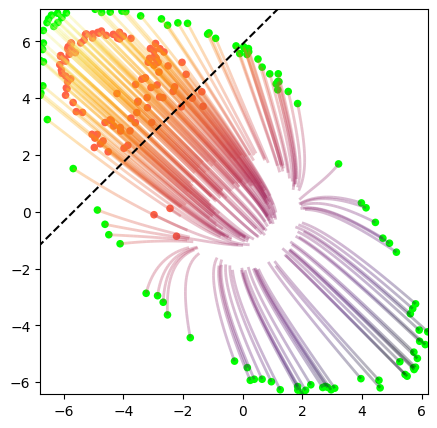

101 0.5769915580749512
102 0.5754978656768799
103 0.5740126371383667
104 0.5725376009941101
105 0.5710737705230713
106 0.569621205329895
107 0.5681794881820679
108 0.5667475461959839
109 0.5653244256973267
110 0.5639088153839111
111 0.5624998807907104
112 0.5610966086387634
113 0.5596985816955566
114 0.5583049654960632
115 0.5569148063659668
116 0.5555269718170166
117 0.5541403889656067
118 0.5527534484863281
119 0.5513647198677063
120 0.5499728918075562
121 0.5485768914222717
122 0.5471758246421814
123 0.5457690358161926
124 0.5443564057350159
125 0.5429376363754272
126 0.5415130853652954
127 0.5400827527046204
128 0.5386469960212708
129 0.5372061133384705
130 0.5357604622840881
131 0.5343104600906372
132 0.5328564047813416
133 0.5313988327980042
134 0.5299379825592041
135 0.5284740924835205
136 0.5270070433616638
137 0.5255367159843445
138 0.5240626335144043
139 0.522584080696106
140 0.5211004614830017
141 0.5196110606193542
142 0.5181151628494263
143 0.51661217212677
144 0.515101969

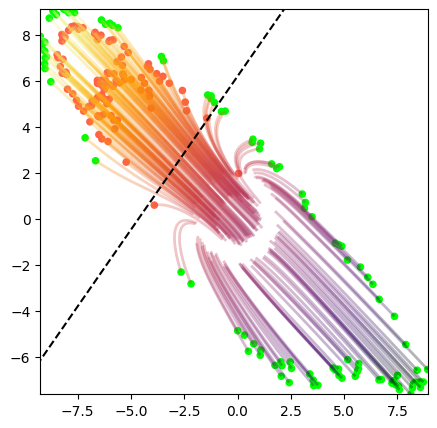

201 0.4078579246997833
202 0.4056793451309204
203 0.40351542830467224
204 0.4013667404651642
205 0.39923369884490967
206 0.39711642265319824
207 0.39501410722732544
208 0.3929254412651062
209 0.3908485174179077
210 0.38878172636032104
211 0.38672345876693726
212 0.38467222452163696
213 0.38262686133384705
214 0.3805868327617645
215 0.37855178117752075
216 0.37652096152305603
217 0.374492883682251
218 0.37246641516685486
219 0.37044113874435425
220 0.36841684579849243
221 0.3663921654224396
222 0.3643641471862793
223 0.3623298704624176
224 0.3602863550186157
225 0.3582296371459961
226 0.3561534881591797
227 0.354050874710083
228 0.3519197702407837
229 0.34976908564567566
230 0.3476094603538513
231 0.3454369306564331
232 0.34324443340301514
233 0.3410351276397705
234 0.3388132154941559
235 0.33657485246658325
236 0.3343117833137512
237 0.3320196270942688
238 0.3297002911567688
239 0.3273564577102661
240 0.32498931884765625
241 0.32259899377822876
242 0.3201829791069031
243 0.317739158868

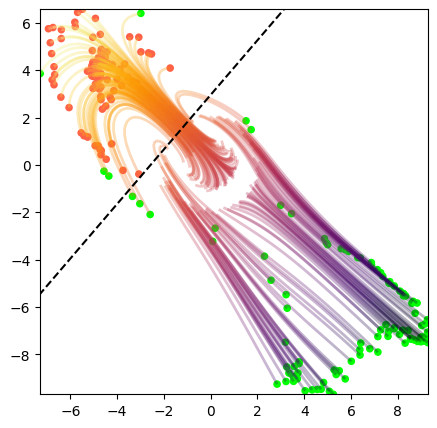

301 0.16095420718193054
302 0.15915600955486298
303 0.15738236904144287
304 0.1556277722120285
305 0.15389102697372437
306 0.15216432511806488
307 0.15044911205768585
308 0.14873512089252472
309 0.14702896773815155
310 0.14533020555973053
311 0.1436517834663391
312 0.1419927030801773
313 0.14034835994243622
314 0.13871915638446808
315 0.13711144030094147
316 0.1355312168598175
317 0.1340188831090927
318 0.13267460465431213
319 0.13207827508449554
320 0.12947703897953033
321 0.12879419326782227
322 0.1285851001739502
323 0.12620314955711365
324 0.12540480494499207
325 0.12283255159854889
326 0.12234620749950409
327 0.12063903361558914
328 0.11962179094552994
329 0.11819086968898773
330 0.11716704070568085
331 0.11609572917222977
332 0.1147245317697525
333 0.11398351937532425
334 0.11266923695802689
335 0.11189565062522888
336 0.11049545556306839
337 0.10994081944227219
338 0.10854065418243408
339 0.10789276659488678
340 0.10664692521095276
341 0.10601376742124557
342 0.10481210052967072

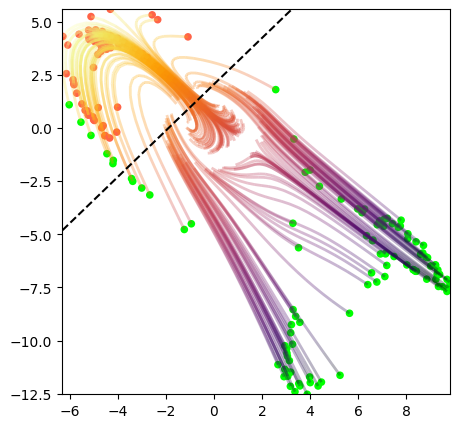

401 0.06958872079849243
402 0.0692012757062912
403 0.06879785656929016
404 0.06844072788953781
405 0.06805818527936935
406 0.06767965108156204
407 0.0673346221446991
408 0.06694258004426956
409 0.06659962981939316
410 0.06623250991106033
411 0.06588949263095856
412 0.06555023789405823
413 0.06520266830921173
414 0.06488015502691269
415 0.06452783942222595
416 0.06420391798019409
417 0.06387234479188919
418 0.06356076151132584
419 0.0632370263338089
420 0.06291922181844711
421 0.06260817497968674
422 0.06228791922330856
423 0.06199078634381294
424 0.06169765442609787
425 0.06136951968073845
426 0.06109745055437088
427 0.06078226864337921
428 0.06047553941607475
429 0.06020253151655197
430 0.05989813804626465
431 0.05961037799715996
432 0.05933346226811409
433 0.05903097614645958
434 0.05875948444008827
435 0.058478955179452896
436 0.058189645409584045
437 0.05792395770549774
438 0.057653263211250305
439 0.05736824870109558
440 0.05714559182524681
441 0.05686856061220169
442 0.0566121228

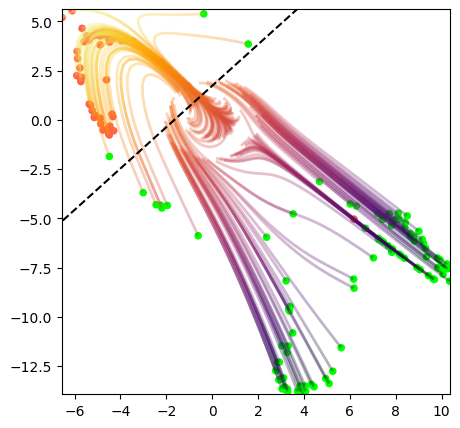

In [13]:
from matplotlib.collections import LineCollection

ii = 0
odefunc = ODEFunc().to(device)
model = Model(odefunc).to(device)

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)

for itr in range(1, 501):
    optimizer.zero_grad()
    #x0, y = sample_annuli(device=device, n_samples=1024)
    yh = model(Xtrain)
    loss = nn.BCELoss()(yh[-1], ytrain[:,None].float())
    print(itr,loss.item())
    loss.backward()
    optimizer.step()

    if itr % 100 == 0:
        with torch.no_grad():
            x0, ys = sample_annuli(n_samples=200) ; s = torch.linspace(0, 1, 20)
            xS = odeint(model.odefunc, x0, s).to(device)
            r = 1.05*torch.linspace(xS[:,:,-2].min(), xS[:,:,-2].max(), 2)
            pS = torch.cat([model.linear_layer(xS[:,i,-2:].to(device))[None,:,:] for i in range(len(x0))])

            fig, ax = plt.subplots(1, 1, figsize=(5,5), sharex=True, sharey=True)
            for i in range(len(x0)):
                x, y, p = xS[:,i,-2].numpy(), xS[:,i,-1].numpy(), model.linear_layer(xS[:,i,-2:].to(device)).view(-1).detach().cpu().numpy()
                points = np.array([x, y]).T.reshape(-1, 1, 2) ; segments = np.concatenate([points[:-1], points[1:]], axis=1)
                norm = plt.Normalize(pS.min(), pS.max())
                lc = LineCollection(segments, cmap='inferno', norm=norm, alpha=.3)
                lc.set_array(p) ; lc.set_linewidth(2) ; line = ax.add_collection(lc)
            pS_ = model.linear_layer(xS[-1,:,-2:].to(device)).view(-1).detach().cpu().numpy()
            
            colors = ['lime','tomato']
            for i in range(200):
                ax.scatter(xS[-1,i,-2], xS[-1,i,-1], c=colors[ys[i]], edgecolor='none', s=30)
#            ax.scatter(xS[-1,:,-2], xS[-1,:,-1], c='lime', edgecolor='none', s=30)
#            ax.scatter(xS[0,:,-2], xS[0,:,-1], c='black', alpha=.5, s=30)
            ax.plot(r, dec_bound(model, r), '--k')
            ax.set_xlim(xS[:,:,-2].min(), xS[:,:,-2].max()) ; ax.set_ylim(xS[:,:,-1].min(), xS[:,:,-1].max())
            plt.show()

In [14]:
label = (yh[1,:,0] >= 0.5).long()

In [15]:
print((torch.abs(label)-torch.abs(ytrain)).sum()/1024)

tensor(0.0166)


<b>[Questions]</b>

You can see that the neural ODEs fail to achieve 100% accuracy. This is somewhat odd considering that the simple shallow network could achieve 100% accuracy and NODEs are an advanced version of ResNets. 

[3 pts] Can you explain why NODEs (by design) fail and are not suitable for performing this task?

NODEs (by design) model data through continuous transformations by creating unique trajectories in the feature space. These trajectories are contiinuous and can diverge or intersect, unlike traditional neural networks in which the transformations are discrete and do not intersect. This characteristic of NODEs makes it not suitable for performing tasks that need to output distinct decision boundaries, such as this task. The smooth and continuous trajectories of NODE transformations might either result in under-smoothing (which may lead to losing the underlying continuous nature) or over-smoothing (which may fail to capture important boundaries). Therefore, NODEs are less suitable for tasks need to precise and distinct decision boundaries even though they are powerful and flexible.

[4 pts] now implement variants of NODEs that overcome the issue of NODEs shown above. Any variant of NODE will be accepted. The resulting model should achieve 100% accuracy. Following is the one such variant. See the implementation below (Not all parts of the implementation is revealed; I removed one important block myDepthCat.) 

In [16]:
class myDepthCat(nn.Module):
    def __init__(self, dim):
        super(myDepthCat, self).__init__()
        self.dim = dim
        self.t = None

    def forward(self, x):
        return torch.cat((x, torch.full((x.shape[0], 1), self.t.item())), self.dim)

In [17]:
class ODEFunc(nn.Module):
    def __init__(self):
        super(ODEFunc, self).__init__()

        hdim = 32
        self.net = nn.Sequential(
            myDepthCat(1),
            nn.Linear(2+1, hdim),
            nn.Tanh(),
            myDepthCat(1),
            nn.Linear(hdim+1, hdim),
            nn.Tanh(),
            nn.Linear(hdim, 2)
        )

        #for p in self.net[-1].parameters(): torch.nn.init.zeros_(p)

    def forward(self, t, y):
        for _, module in self.net.named_modules():
            if hasattr(module, 't'):
                module.t = t
        return self.net(y)

In [18]:
class Model(nn.Module):
    def __init__(self,odefunc,device="cpu"):
        super(Model, self).__init__()

        self.odefunc = odefunc
        self.linear_layer = nn.Linear(2,1)
        for p in self.linear_layer.parameters(): torch.nn.init.zeros_(p)

    def forward(self, y):
        t_span = torch.linspace(0., 1., 2)
        pred_y = odeint(self.odefunc, y, t_span).to(device)
        yhat = self.linear_layer(pred_y)
        return yhat

1 0.6931472420692444
2 0.6930944323539734
3 0.6930364370346069
4 0.69297194480896
5 0.692900538444519
6 0.692821741104126
7 0.6927350163459778
8 0.6926400661468506
9 0.6925363540649414
10 0.6924233436584473
11 0.6923004388809204
12 0.6921671032905579
13 0.6920228600502014
14 0.6918669939041138
15 0.6916986107826233
16 0.6915172934532166
17 0.691321849822998
18 0.6911118030548096
19 0.6908859014511108
20 0.690643310546875
21 0.690382719039917
22 0.690102756023407
23 0.6898018717765808
24 0.6894784569740295
25 0.6891301870346069
26 0.688755214214325
27 0.6883511543273926
28 0.6879156827926636
29 0.6874462366104126
30 0.6869404315948486
31 0.6863955855369568
32 0.6858091354370117
33 0.6851786375045776
34 0.6845014691352844
35 0.6837751865386963
36 0.6829977631568909
37 0.6821667551994324
38 0.6812807321548462
39 0.6803381443023682
40 0.679337739944458
41 0.6782789826393127
42 0.677161455154419
43 0.6759851574897766
44 0.6747506856918335
45 0.6734586954116821
46 0.6721106171607971
47 0.670

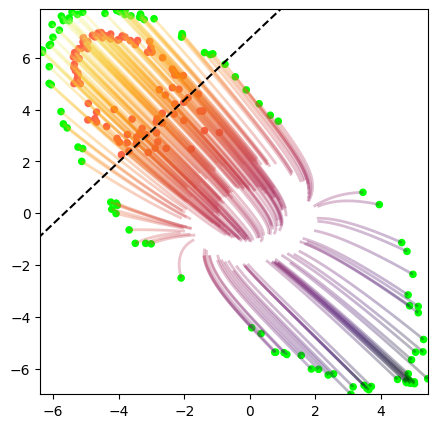

101 0.5853246450424194
102 0.5836873650550842
103 0.5820590257644653
104 0.580436110496521
105 0.5788142681121826
106 0.5771905779838562
107 0.5755648016929626
108 0.5739381313323975
109 0.5723124146461487
110 0.5706888437271118
111 0.5690678954124451
112 0.5674492716789246
113 0.5658323764801025
114 0.5642163753509521
115 0.56260085105896
116 0.5609850883483887
117 0.5593689680099487
118 0.5577515363693237
119 0.5561318397521973
120 0.554507851600647
121 0.5528779029846191
122 0.5512399077415466
123 0.5495926141738892
124 0.5479360222816467
125 0.5462711453437805
126 0.5445995926856995
127 0.5429225564002991
128 0.5412407517433167
129 0.5395550727844238
130 0.5378663539886475
131 0.5361757874488831
132 0.5344847440719604
133 0.5327942371368408
134 0.5311048030853271
135 0.5294156074523926
136 0.5277253985404968
137 0.5260317921638489
138 0.5243321657180786
139 0.522623598575592
140 0.520903468132019
141 0.5191704630851746
142 0.5174252986907959
143 0.5156689882278442
144 0.51390230655

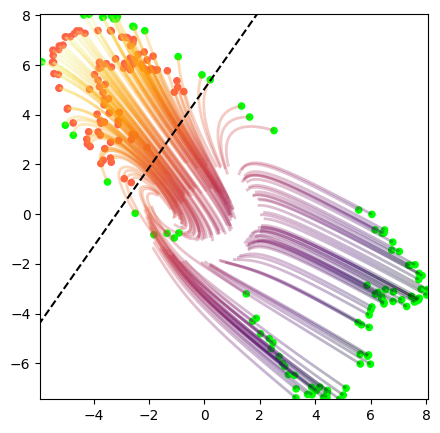

201 0.35590553283691406
202 0.35247930884361267
203 0.3490641415119171
204 0.3456609845161438
205 0.34227198362350464
206 0.33889976143836975
207 0.3355470597743988
208 0.3322158753871918
209 0.32890787720680237
210 0.3256242275238037
211 0.32236576080322266
212 0.3191337287425995
213 0.3159295916557312
214 0.3127552270889282
215 0.3096124827861786
216 0.3065033555030823
217 0.30342966318130493
218 0.30039286613464355
219 0.29739439487457275
220 0.2944350242614746
221 0.2915157079696655
222 0.2886374890804291
223 0.28580161929130554
224 0.2830091118812561
225 0.2802605628967285
226 0.2775561809539795
227 0.2748956084251404
228 0.27227821946144104
229 0.26970261335372925
230 0.26716744899749756
231 0.2646712064743042
232 0.2622123658657074
233 0.25978943705558777
234 0.2574007213115692
235 0.25504451990127563
236 0.252718985080719
237 0.2504223883152008
238 0.2481529712677002
239 0.2459089159965515
240 0.24368880689144135
241 0.24149109423160553
242 0.23931419849395752
243 0.23715658485

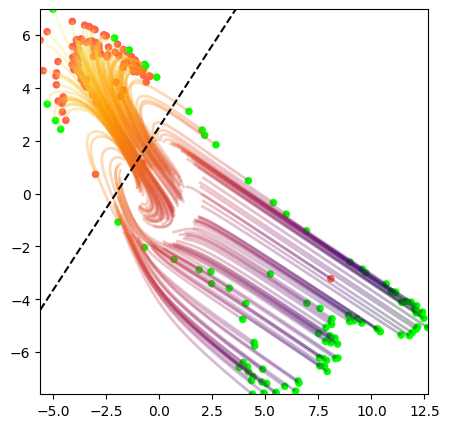

301 0.11911223828792572
302 0.11708033084869385
303 0.11506471037864685
304 0.11306649446487427
305 0.11108667403459549
306 0.10912624001502991
307 0.10718598961830139
308 0.10526658594608307
309 0.10336866229772568
310 0.10149280726909637
311 0.09963959455490112
312 0.09780938923358917
313 0.09600252658128738
314 0.0942191630601883
315 0.09245952218770981
316 0.09072361141443253
317 0.08901139348745346
318 0.08732269704341888
319 0.08565740287303925
320 0.08401535451412201
321 0.08239635825157166
322 0.0808001458644867
323 0.07922648638486862
324 0.07767504453659058
325 0.07614558935165405
326 0.07463782280683517
327 0.07315148413181305
328 0.071686290204525
329 0.07024206966161728
330 0.068818598985672
331 0.06741569936275482
332 0.06603319942951202
333 0.06467092782258987
334 0.06332874298095703
335 0.06200648099184036
336 0.06070404499769211
337 0.05942130088806152
338 0.058158159255981445
339 0.0569145567715168
340 0.05569035932421684
341 0.05448552966117859
342 0.0532999821007251

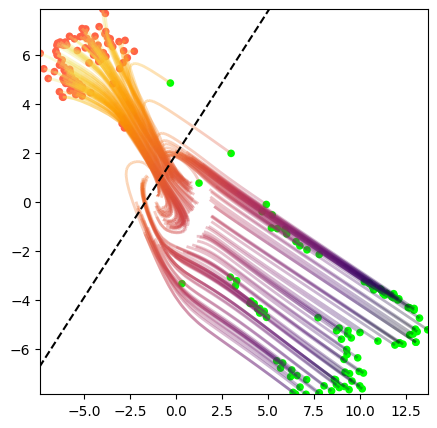

401 0.014806981198489666
402 0.014543226920068264
403 0.014286346733570099
404 0.014036099426448345
405 0.013792311772704124
406 0.013554747216403484
407 0.013323226012289524
408 0.013097548857331276
409 0.012877552770078182
410 0.012663053348660469
411 0.012453878298401833
412 0.012249864637851715
413 0.012050855904817581
414 0.011856711469590664
415 0.011667260900139809
416 0.011482386849820614
417 0.011301923543214798
418 0.011125755496323109
419 0.01095376256853342
420 0.010785812512040138
421 0.010621796362102032
422 0.010461587458848953
423 0.010305071249604225
424 0.010152144357562065
425 0.010002713650465012
426 0.009856661781668663
427 0.009713908657431602
428 0.009574344381690025
429 0.009437884204089642
430 0.009304444305598736
431 0.009173929691314697
432 0.00904627051204443
433 0.008921369910240173
434 0.008799166418612003
435 0.008679582737386227
436 0.008562535047531128
437 0.00844796746969223
438 0.00833580456674099
439 0.008225981146097183
440 0.00811842642724514
441 0

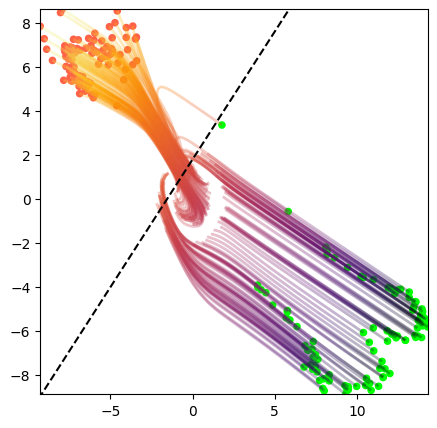

In [19]:
from matplotlib.collections import LineCollection

ii = 0
odefunc = ODEFunc().to(device)
model = Model(odefunc).to(device)

optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-6)

for itr in range(1, 501):
    optimizer.zero_grad()
    #x0, y = sample_annuli(device=device, n_samples=1024)
    yh = model(Xtrain)
    loss = nn.BCELoss()(torch.sigmoid(yh[-1]), ytrain[:,None].float())
    print(itr,loss.item())
    loss.backward()
    optimizer.step()

    if itr % 100 == 0:
        with torch.no_grad():
            x0, ys = sample_annuli(n_samples=200) ; s = torch.linspace(0, 1, 20)
            xS = odeint(model.odefunc, x0, s).to(device)
            r = 1.05*torch.linspace(xS[:,:,-2].min(), xS[:,:,-2].max(), 2)
            pS = torch.cat([model.linear_layer(xS[:,i,-2:].to(device))[None,:,:] for i in range(len(x0))])

            fig, ax = plt.subplots(1, 1, figsize=(5,5), sharex=True, sharey=True)
            for i in range(len(x0)):
                x, y, p = xS[:,i,-2].numpy(), xS[:,i,-1].numpy(), model.linear_layer(xS[:,i,-2:].to(device)).view(-1).detach().cpu().numpy()
                points = np.array([x, y]).T.reshape(-1, 1, 2) ; segments = np.concatenate([points[:-1], points[1:]], axis=1)
                norm = plt.Normalize(pS.min(), pS.max())
                lc = LineCollection(segments, cmap='inferno', norm=norm, alpha=.3)
                lc.set_array(p) ; lc.set_linewidth(2) ; line = ax.add_collection(lc)
            pS_ = model.linear_layer(xS[-1,:,-2:].to(device)).view(-1).detach().cpu().numpy()
            colors = ['lime','tomato']
            for i in range(200):
                ax.scatter(xS[-1,i,-2], xS[-1,i,-1], c=colors[ys[i]], edgecolor='none', s=30)

            ax.plot(r, dec_bound(model, r), '--k')
            ax.set_xlim(xS[:,:,-2].min(), xS[:,:,-2].max()) ; ax.set_ylim(xS[:,:,-1].min(), xS[:,:,-1].max())
            plt.show()

In [20]:
label = (yh[1,:,0] >= 0.5).long()
print((torch.abs(label)-torch.abs(ytrain)).sum()/1024)

tensor(0.)
